## Simple GP and Math

This notebook shows the simplest version of GP extracted from PyMRA, along with math. 
Denote $C$ as the covariance function, $x$ as locations with known observations, $y$ as AOD values, $x^*$ as locations with unknown observations. 
$$
y = f(x) \sim N (\mu, C(x,x)) 
$$
Given unknown locations $x^*$ we want to predict their values $y^*$, following joint Gaussian distribution, 
$$
\left[
\begin{matrix}
    y \\
    y^* \\
\end{matrix}
\right]
\sim
N \left( \left[
\begin{matrix}
\mu \\
\mu^* \\ 
\end{matrix}
\right], 
\left[
\begin{matrix}
C(x,x) & C(x,x^*) \\
C(x,x^*)^{T} & C(x^*,x^*) \\
\end{matrix}
\right] \right), 
$$
because of **conditioning the joint Gaussian prior distribution on the observations**, we have 
$$
y^* | x^*, x, y \sim N\left(C(x,x^*)^T C(x,x)^{-1} y + \mu, C(x^*,x^*) - C(x,x^*)^T C(x,x)^{-1} C(x,x^*)    \right)
$$


Now we simplify the notations. Define 
$$
B = C(x,x^*), \\
K = C(x,x), \\
\mu = 0, \\
$$
then, the formula can be rewritten as 
$$
y^* \sim N\left(B^T K^{-1} y , C(x^*,x^*) - B^T K^{-1} B    \right)
$$

**The marginal likelihood is the integral of the likelihood times the prior** 
$$
p(y|X) = \int{p(y|f, X)p(f|X)d\mathbf{f}}.
$$
Under GP, the prior is Gaussian, $y|X \sim N(0,K)$, or 
$$
\log p (y|X)  = - \frac{1}{2} y^T K^{-1} y - \frac{1}{2} \log |K| - \frac{n}{2} \log (2\pi) \\
  \sim = - y^T K^{-1} y - \log |K| 
$$



## Import packages

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cdist
import scipy.linalg as lng
from numpy.linalg import slogdet
from sklearn.metrics import r2_score, mean_squared_error
import scipy
import time
import scipy.optimize as opt
import logging

In [ ]:
#%% Additional setting for Google Cloud
!git clone https://github.com/sjliu68/pyMRAsampleData.git

## Load dataset, generate random unobserved points, same as earlier, ignore this part

- make sure data are saved under saved folder
- x1,x2: two dimensional locations
- mean: AOD values

Google Cloud Version: the first three lines are different (loading data). 

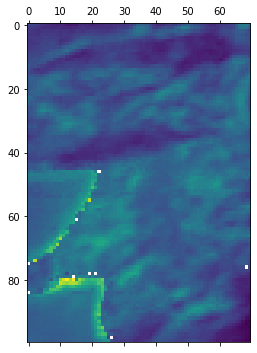

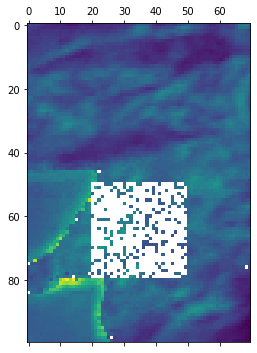

In [2]:
#%% load dataset, can ignore this part
x1 = np.load('pyMRAsampleData/xlon2019.npy')
x2 = np.load('pyMRAsampleData/xlat2019.npy')
mean = np.load('pyMRAsampleData/mean2019.npy')    
mean -= 97
mean /= 10

imx1,imx2,imy1,imy2 = 670,770,190,260

data = mean[imx1:imx2,imy1:imy2]
data2 = copy.deepcopy(mean[imx1:imx2,imy1:imy2])
plt.matshow(data)
plt.show()


x1 = x1[imx1:imx2,imy1:imy2]
x2 = x2[imx1:imx2,imy1:imy2]
x1 -= x1.min()
x2 -= x2.min()
x1 /= x1.max()
x2 /= x2.max()


### make random train/test
np.random.seed(42)
_x = 50
_y = 20
n = 30
data[_x:_x+n,_y:_y+n] = np.nan
for i in range(n):
    for j in range(n):
        if np.random.rand()<0.2:
            data[_x+i,_y+j] = data2[_x+i,_y+j]

plt.matshow(data)
plt.show()

#%
idx = np.isnan(data)
train_y = data[~idx]
train_x1 = x1[~idx]
train_x2 = x2[~idx]


test_x1 = x1[idx]
test_x2 = x2[idx]
test_y = data2[idx]
test_X = np.asarray([test_x1,test_x2]).T
train_X = np.asarray([train_x1,train_x2]).T

idx2 = np.isnan(test_y)
test_y2 = test_y[~idx2]

### overwrite here, make all data including nan
train_y = data.reshape(-1,1)
idx = np.arange(train_y.shape[0])
train_X = np.asarray([x1.reshape(-1),x2.reshape(-1)]).T

## Base function to generate distance matrix

In [3]:
#%%
def dist(locs, locs2=np.array([]), circular=False):
    locs = locs if np.ndim(locs)==2 else np.reshape(locs, [len(locs), 1])
    if circular:
        if len(locs2):
            xv, yv = np.meshgrid(locs, locs2)
        else:
            xv, yv = np.meshgrid(locs, locs)
        m = np.minimum(xv, yv)
        M = np.maximum(xv, yv)
        dist = np.matrix(np.minimum(M - m, m + 1-M).T)
    else:
        if len(locs2):
            dist = np.matrix(cdist(locs, locs2))
            # dist = cdist(locs, locs2)
        else:
            dist = np.matrix(squareform(pdist(locs)))
    return dist


def ExpCovFun(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    covMat = np.exp(-D/l)
    return(covMat)

def GetD(locs, locs2=np.array([]), l=1, circular=False):
    D = dist(locs, locs2, circular)
    # covMat = np.exp(-D/l)
    return(D)


## Three functions of simple GP
    function 1: directGPsimple, only generate mean and var
    function 2: directGPsimple2, add likelihood & sigma parameter
    function 3: directGPprojection, the original version used in PyMRA, there is a projection operation for y: y_new = B.T * y

In [4]:
#%%
if False: 
    # this if only used in debug
    X = train_X
    y = train_y
    phi = 0.5

def directGPsimple(X,y,phi=0.5):
    locs = X
    
    # find only valid data, index
    obs = np.matrix(y)
    obs_inds = np.where(np.logical_not(np.isnan(obs)))[0]
    
    # knots
    knots = locs[obs_inds]
    kInds = obs_inds
    
    B = np.exp(-phi * GetD(locs,knots)) # C(x,x*)
    K = B[kInds,:] # C(x,x)
    Kinv = np.linalg.inv(K) # C(x,x)^{-1}
    
    # posterior
    obsInds = np.array(np.isfinite(obs)).ravel() # True/False
    
    mean = B * np.matrix(Kinv) * obs[obsInds]
    var = np.exp(-phi * GetD(locs,locs)) - B*Kinv*B.T

    return mean, var

def directGPsimple2(X,y,phi=0.5,sigma=1):
    # version 2, add likelihood and sigma
    # GP4ML: http://gaussianprocess.org/gpml/chapters/RW.pdf
    
    locs = X
    
    # find only valid data, index
    obs = np.matrix(y)
    obs_inds = np.where(np.logical_not(np.isnan(obs)))[0]
    
    # knots
    knots = locs[obs_inds]
    kInds = obs_inds
    
    B = sigma**2 * np.exp(-phi * GetD(locs,knots)) # C(x,x*)
    K = B[kInds,:] # C(x,x)
    Kinv = np.linalg.inv(K) # C(x,x)^{-1}
    
    # posterior
    obsInds = np.array(np.isfinite(obs)).ravel() # True/False
    
    mean = B * np.matrix(Kinv) * obs[obsInds]
    var = sigma**2 * np.exp(-phi * GetD(locs,locs)) - B*Kinv*B.T
    
    
    # add likelihood
    sgn, logdetK = slogdet(K) # LU decomposition via LAPACK routine
    
    loglike1 = - obs[obsInds].T * Kinv * obs[obsInds]
    loglike2 = - sgn*logdetK
    
    loglike = loglike1[0,0] + loglike2

    return mean, var, loglike

def directGPprojection(X,y,phi=0.5,sigma=1):
    # version 3, add projection
    # GP4ML: http://gaussianprocess.org/gpml/chapters/RW.pdf
    
    factor = 10000 # precision?
    
    locs = X
    
    # find only valid data, index
    obs = np.matrix(y)
    obs_inds = np.where(np.logical_not(np.isnan(obs)))[0]
    
    # knots
    knots = locs[obs_inds]
    kInds = obs_inds
    
    B = sigma**2 * np.exp(-phi * GetD(locs,knots)) # C(x,x*)
    K = B[kInds,:] # C(x,x)
    Kinv = np.linalg.inv(K) # C(x,x)^{-1}
    
    # posterior
    obsInds = np.array(np.isfinite(obs)).ravel() # True/False
    
    H = np.matrix(np.eye(len(obs)))[obsInds,:]
    HRinvH = H.T * H * factor # not eye matrix
    HRinvObs = H.T * obs[obsInds] * factor
    omg = B.T*HRinvObs # projection
    A = B.T*HRinvH*B
    
    kTil = np.matrix(lng.inv(K+A))
    
    
    mean = B * kTil * omg
    var = sigma**2 * np.exp(-phi * GetD(locs,locs)) - B*Kinv*B.T
    
    
    # add likelihood
    sgn, logdetK = slogdet(K) # LU decomposition via LAPACK routine
    
    loglike1 = - omg.T * Kinv * omg
    loglike2 = - sgn*logdetK
    
    loglike = loglike1[0,0] + loglike2

    return mean, var, loglike


## Run results from three functions, all three are comparable to each other

In [5]:
#%% all the three results are comparable to each other
result = directGPsimple(train_X, train_y, phi=0.5)
result2 = directGPsimple2(train_X, train_y, phi=0.5)
result3 = directGPprojection(train_X, train_y, phi=0.5)

## Scatter plots, R^2=0.793
- ypre = result[0], test 1st function
- ypre = result2[0], test 2nd function
- ypre = result3[0], test 3rd function

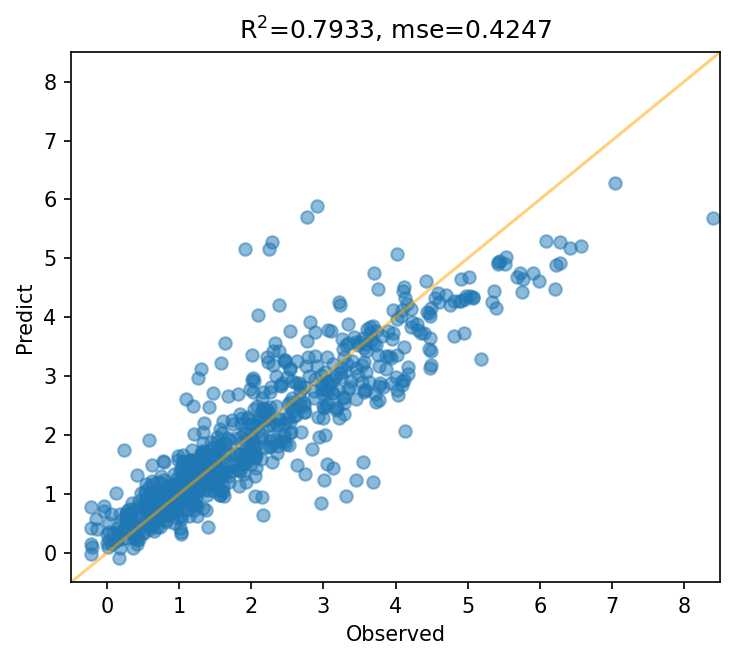

In [6]:
#%% test if mean is correct
ypre = result[0] # ypre=result2[0], ypre=result3[0]
idx = np.where(np.isnan(train_y)) # test only on unknown locations
y2p = ypre[idx]
y2p = np.squeeze(np.asarray(y2p))
y2g = data2.reshape(-1,1)[idx]

# further cleanup. data originally contain NaN
idx2 = np.isnan(y2g)
y2g2 = y2g[~idx2]
y2p2 = y2p[~idx2]


# plot data
r2 = r2_score(y2g2, y2p2)
mse = mean_squared_error(y2g2, y2p2)

fig = plt.figure(figsize=(5,4.5),dpi=150)
plt.plot(np.arange(-5,10),np.arange(-5,10),c='orange',alpha=0.5)
plt.scatter(y2g,y2p,alpha=0.5)
plt.xlabel('Observed')
plt.ylabel('Predict')
plt.title('R$^2$='+f'{r2:.4f}'+', mse='+f'{mse:.4f}')
plt.xlim(-0.5,8.5)
plt.ylim(-0.5,8.5)
plt.tight_layout()
plt.show()

## Toy Example testing hyperparameters, one-dimensional

In [10]:
#%% toy example for testing hyperparameters
phi = 0.5
sigma = 1.1
nb_of_samples = 100
number_of_functions = 1

X = np.expand_dims(np.linspace(-8, 8, nb_of_samples), 1)
cmatrix = sigma**2 * np.exp(-phi * GetD(X,X)) # C(x,x*)
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=cmatrix)
ys = ys.reshape(-1,1)


# get parameters
def negativeloglikelihood(params):
    time1 = time.time()
    _,_,l = directGPsimple2(X=X,y=ys,phi=params[0],sigma=params[1])
    time2 = time.time()
    print(l, params)
    print('time in seconds:', time2-time1)
    return -l

params = {}
params['phi'] = 0.2
params['sigma'] = 1.2
xmin = opt.minimize(negativeloglikelihood, [params['phi'],params['sigma']], bounds=((1e-4, 1e4),(1e-4, 1e4)), method='L-BFGS-B')
# xmin = opt.minimize(negativeloglikelihood, [params['phi'],params['sigma']], bounds=((1e-4, 1e4),(1e-4, 1e4)), method='SLSQP')
# xmin = opt.minimize(negativeloglikelihood, [params['phi'],params['sigma']], bounds=((1e-4, 1e4),(1e-4, 1e4)), method='nelder-mead', options={'xtol':1e-3,'disp':True})
logging.info(str(xmin))
print(xmin)


55.70031684912527 [0.2 1.2]
time in seconds: 0.0009996891021728516
55.70032096592308 [0.20000001 1.2       ]
time in seconds: 0.0010001659393310547
55.70031821848386 [0.2        1.20000001]
time in seconds: 0.0019979476928710938
-985.6552956430679 [411.87978133 138.1358594 ]
time in seconds: 0.0029973983764648438
-985.6552956430679 [411.87978134 138.1358594 ]
time in seconds: 0.0019989013671875
-985.6552956575421 [411.87978133 138.13585941]
time in seconds: 0.0029981136322021484
-767.3968367917938 [135.99592941  46.3694087 ]
time in seconds: 0.0029981136322021484
-767.3968367917938 [135.99592942  46.3694087 ]
time in seconds: 0.001999378204345703
-767.3968368348967 [135.99592941  46.36940871]
time in seconds: 0.0029985904693603516
-553.7270308982806 [44.36444614 15.89029246]
time in seconds: 0.002999544143676758
-553.7270308982821 [44.36444615 15.89029246]
time in seconds: 0.00299835205078125
-553.7270310234065 [44.36444614 15.89029247]
time in seconds: 0.0019986629486083984
-355.46171